**1) Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Matplotlib is building the font cache; this may take a moment.


**2) Loading data**

In [2]:
# Load sales data
df = pd.read_csv("sales_data.csv", parse_dates=["ds"])
df.set_index("ds", inplace=True)
df.head()

,y
ds,
2025-01-01,110.794951
2025-01-02,100.054696
2025-01-03,117.732556
2025-01-04,137.197422
2025-01-05,104.010777


**3) Feature Engineering (feature creation)**

In [3]:
# Feature Engineering
df["lag_1"] = df["y"].shift(1)  # Yesterday's sales
df["lag_7"] = df["y"].shift(7)  # Weekly lag
df["rolling_mean_7"] = df["y"].rolling(window=7).mean()  # 7-day moving average
df["dayofweek"] = df.index.dayofweek
df["quarter"] = df.index.quarter #new line------------------
df["month"] = df.index.month
df['dayofmonth'] = df.index.day #new line------------------
df.dropna(inplace=True)  # Drop missing values

**4) Model Training**

In [4]:
# Prepare training data
X_train, y_train = df.drop(columns=["y"]), df["y"]

# Train XGBoost Model on the full dataset
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

**5) Model Evaluation**

In [5]:
# Model Evaluation on training data
y_pred_train = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2:.4f}")

MAE: 3.79, RMSE: 5.16, R2 Score: 0.9968


**6) Forecasting 2026 sales**

In [6]:
# Forecasting for 2026
future_dates = pd.date_range(start="2026-01-01", end="2026-12-31", freq="D")
future_df = pd.DataFrame(index=future_dates)
future_df["month"] = future_df.index.month
future_df["dayofweek"] = future_df.index.dayofweek
future_df["quarter"] = future_df.index.quarter #new line------------------
future_df["dayofmonth"] = future_df.index.day #new line------------------

# Iterative Forecasting
last_known_data = df.copy()
forecast_values = []

for date in future_dates:
    # Get last known values for lag features
    lag_1 = last_known_data.loc[date - pd.Timedelta(days=1), "y"] if date - pd.Timedelta(days=1) in last_known_data.index else np.nan
    lag_7 = last_known_data.loc[date - pd.Timedelta(days=7), "y"] if date - pd.Timedelta(days=7) in last_known_data.index else np.nan
    rolling_mean_7 = last_known_data["y"].rolling(window=7).mean().iloc[-1] if len(last_known_data) >= 7 else np.nan

    # Create feature row
    future_row = pd.DataFrame({
        "lag_1": [lag_1],
        "lag_7": [lag_7],
        "rolling_mean_7": [rolling_mean_7],
        "dayofweek": [date.dayofweek],
        "quarter": [date.quarter], #new line------------------
        "month": [date.month],
        "dayofmonth": [date.day] #new line------------------

    })

    # Predict
    y_pred_future = model.predict(future_row)[0]

    # Store forecast
    forecast_values.append(y_pred_future)

    # Add to dataset for next iteration
    last_known_data.loc[date] = {"y": y_pred_future}

# Store forecasted data
future_df["y"] = forecast_values

**7) 2026 Forecast Plot**

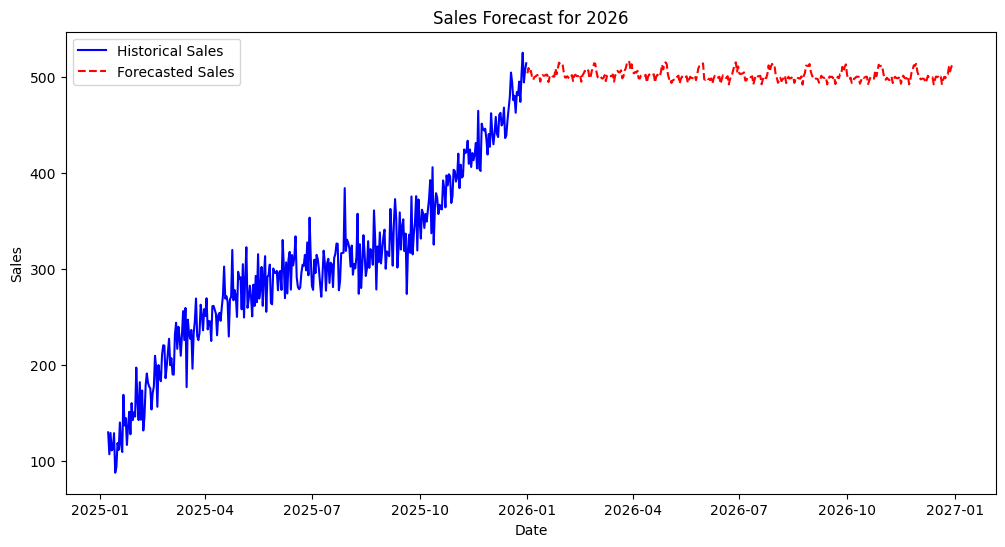

In [7]:
# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["y"], label="Historical Sales", color="blue")
plt.plot(future_df.index, future_df["y"], label="Forecasted Sales", color="red", linestyle="dashed")
plt.legend()
plt.title("Sales Forecast for 2026")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [23]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define parameter grid
param_grid = {
    'n_estimators': [10, 200],  
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 10],  
    'subsample': [0.8, 0.9],  
    'colsample_bytree': [0.8, 0.9]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=10,  # Reduced CV for speed
                           n_jobs=-1, verbose=1)

# Fit GridSearch to the data
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Train model with best parameters
best_model = xgb.XGBRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate performance
y_pred_train = best_model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2:.4f}")

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
MAE: 6.18, RMSE: 7.96, R2 Score: 0.9924
